## Using the Understorey Crown Delineation on NEON AOP Discrete Lidar Data over the Harvard Forest Smithsonian Institute ForestGEO plot 

Harvard Forest Megaplot: http://harvardforest.fas.harvard.edu/other-tags/mega-plot


 

In [1]:
#Importing Libraries from Biomass and Canopy Delineation code:  http://neondataskills.org/lidar/calc-biomass-py/

import numpy as np
import os
import gdal, osr
import matplotlib.pyplot as plt
import sys
from scipy import ndimage as ndi
%matplotlib inline 

#Import biomass specific libraries
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from sklearn.ensemble import RandomForestRegressor

#Define plot band array function

def plot_band_array(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(band_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)  

In [2]:
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [3]:
# %load neon_aop_lidar_raster_functions.py
import gdal, osr 
import numpy as np

def raster2array(geotif_file):
    
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()
    
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]
    
    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])
    
    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()
        
        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)
        
        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==metadata['noDataValue']]=np.nan
        array = array/metadata['scaleFactor']
        array = array[::-1] #inverse array because Python is column major
        return array, metadata
    
    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')
        
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

### Read in CHM and check the projection

In [6]:
chm_file = '/Users/elizabethlarue/Documents/neon/Project/NEON-DI-2017-understory-group/data/dropFirst_v2.tif'

In [7]:
#Open the CHM file with GDAL
chm_dataset = gdal.Open(chm_file)

#Get the raster band object
chm_raster = chm_dataset.GetRasterBand(1)

#Get the NO DATA value
noDataVal_chm = chm_raster.GetNoDataValue()

#Get required metadata from CHM file
cols_chm = chm_dataset.RasterXSize
rows_chm = chm_dataset.RasterYSize
bands_chm = chm_dataset.RasterCount
mapinfo_chm =chm_dataset.GetGeoTransform()
xMin = mapinfo_chm[0]
yMax = mapinfo_chm[3]
xMax = xMin + chm_dataset.RasterXSize/mapinfo_chm[1]
yMin = yMax + chm_dataset.RasterYSize/mapinfo_chm[5]
image_extent = (xMin,xMax,yMin,yMax)
print(image_extent)

#chm_ground_file = '/Users/elizabethlarue/Documents/neon/Project/NEON-DI-2017-understory-group/data/ground_v2.tif'
#check that geotif data was assembled properly in LAS
print('driver:',chm_dataset.GetDriver().LongName)
print('projection:',chm_dataset.GetProjection())
print('geotransform:',chm_dataset.GetGeoTransform())

(731592.0, 732289.0, 4713222.0, 4713723.0)
driver: GeoTIFF
projection: 
geotransform: (731592.0, 1.0, 0.0, 4713723.0, 0.0, -1.0)


### Plot the Canopy height model

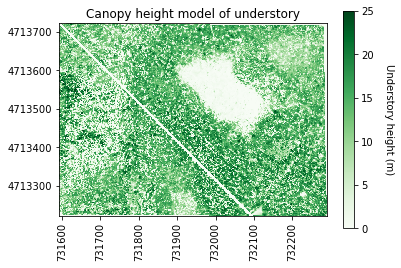

In [8]:
#Plot the original CHM
plt.figure(1)
chm_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)

#PLot the CHM figure
plot_band_array(chm_array,image_extent,'Canopy height model of understory','Understory height (m)','Greens',[0,25])

### Plot a histogram of the understory canopy height

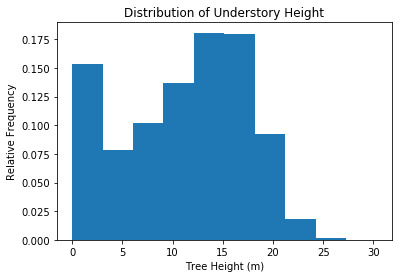

In [9]:
#plot histogram of data
import copy
chm_nonan_array = copy.copy(chm_array)
chm_nonan_array = chm_nonan_array[~np.isnan(chm_array)] #remove NA data
chm_nonan_array = chm_nonan_array[chm_nonan_array > 0] #some weird points so need to remove points less than zero
plt.hist(chm_nonan_array,weights=np.zeros_like(chm_nonan_array)+1./
       (chm_array.shape[0]*chm_array.shape[1]),bins=10);
plt.title('Distribution of Understory Height')
plt.xlabel('Tree Height (m)'); plt.ylabel('Relative Frequency')

The understory appears to be less than 28 m in height

### Apply a Gaussian smoothing kernal (convolution) to smooth the tree crowns

In [10]:
#Smooth the CHM using a gaussian filter to remove spurious points
chm_array_smooth = ndi.gaussian_filter(chm_array,2,mode='constant',cval=0,truncate=2.0)
chm_array_smooth[chm_array==0] = 0 

In [11]:
#Save the smoothed CHM
array2raster('/Users/elizabethlarue/Documents/neon/Project/NEON-DI-2017-understory-group/data/chm_filter.tif',(xMin,yMax),1,-1,np.array(chm_array_smooth/10000,dtype=float),32611)

### Calculate local maximum of crowns

In [12]:
#Calculate local maximum points in the smoothed CHM
local_maxi = peak_local_max(chm_array_smooth,indices=False, footprint=np.ones((10, 10))) #change footprint to be larger

In [13]:
#Identify all the maximum points
markers = ndi.label(local_maxi)[0]

### Create a mask so that only crowns are included in analysis

In [14]:
#Create a CHM mask so the segmentation will only occur on the trees
chm_mask = chm_array_smooth
chm_mask[chm_array_smooth != 0] = 1

### Conduct watershed segmentation to delineate individual trees 

In [15]:
#Perfrom watershed segmentation        
labels = watershed(chm_array_smooth, markers, mask=chm_mask)

In [16]:
#Get the properties of each segment
tree_properties = regionprops(labels,chm_array, ['Area','BoundingBox','Centroid','Orientation','MajorAxisLength','MinorAxisLength','MaxIntensity','MinIntensity'])

### Determine number of individuals

In [17]:
#Determine how many individual trees were identified
max_labels = labels.max()
segment_labels = np.zeros(max_labels+1)
segment_id = np.zeros(max_labels+1)

for counter in range (1,max_labels+1):
    segment_labels[counter] = len(labels[labels==counter])
    segment_id[counter]=counter
    
#Remove the non-zero elements
segment_id = segment_id[np.nonzero(segment_labels)]

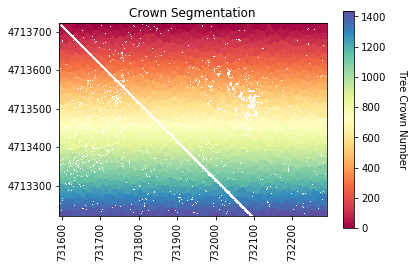

In [18]:
#Change the lebels to flow and plot them and save as raster
labels = np.array((labels),dtype=float)
plt.figure(3)
#array2raster('C:/RSDI_2017/Day4/Biomass/SegmentedData.tif',(xMin,yMax),1,-1,labels,32611)
#Change the zero labels to nans so they won't show up in the plot
labels[labels==0] = np.nan
      
#Plot the segments      
plot_band_array(labels,image_extent,'Crown Segmentation','Tree Crown Number','Spectral',[0, max_labels])

### Plot local maxi points to compare to dbh map from Smithsonian data

Why does the maximum point plot look different from the crown number map?

number of crowns: 501


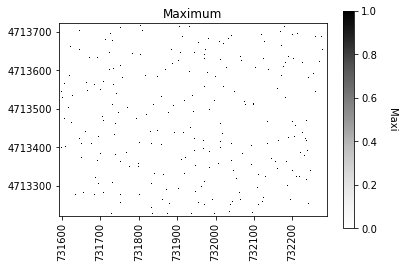

In [19]:
plt.figure(2)
plot_band_array(local_maxi,image_extent,'Maximum','Maxi','Greys',[0, 1])
print('number of crowns:',len(local_maxi))

There are 70,000 trees with a DBH < 5 cm in this area.

### Output Geotif for comparison in QGIS

In [20]:
#used array2raster to create GEOTiff from model written by Bridget
rasterOrigin =[731592.9,4713221.9]
chm_output = array2raster('Understory_CHM_.tif',rasterOrigin,1 ,1 ,local_maxi,32618)
#1. output file name
#2. raster origin (upper left hand corner)
#3. pixel width (1)
#4. pixel height (-1)
#5. epgs code (from GetProjection)